In [6]:
from torch.utils.data import DataLoader
from kneed import KneeLocator

import nemo.collections.asr as nemo_asr
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torchaudio
import torch
import math
import json

In [12]:
def jitter_loss(A):
    A_t = A[:-1]
    A_t_1 = A[1:]
    return torch.mean(torch.abs(A_t - A_t_1))

In [15]:
a = torch.arange(0, 100).view(-1, 10).float()

In [ ]:
np.inner(a,a), np.linalg.norm(a, ord=2)

[NeMo W 2025-04-18 15:55:38 nemo_logging:349] /tmp/ipykernel_2317476/2346483293.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
      np.inner(a,a).mean(), np.linalg.norm(a, ord=2)
    


(np.float32(24585.0), np.float32(572.8373))

In [2]:
a = torch.rand((780 * 1500 // 100, 1280))
# a = a.reshape(-1, 1280)
u,s,v = np.linalg.svd(a.to(torch.float32))

In [3]:
knee = KneeLocator(np.arange(s.shape[0]), s, S=1.0, curve='concave', direction='decreasing')

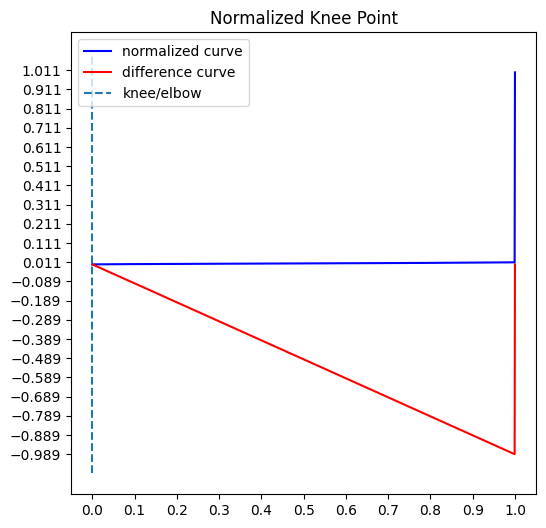

In [4]:
knee.plot_knee_normalized()

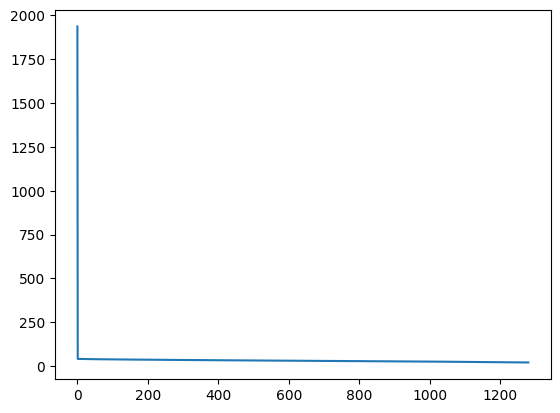

In [5]:
plt.plot(np.arange(s.shape[0]), s)
plt.show()

In [4]:
a = DataLoader(torch.ones(512, 48000), batch_size=256)
next(iter(a)).shape

torch.Size([256, 48000])

In [ ]:
a = torch.tensor([[(i+1)**(-(j+1)) for j in range(-25,-15)] for i in range(3)]).reshape(3,10).float()
unit_disk = torch.div(a, torch.norm(a, p=2, dim=1).view(-1,1))
unit_disk

tensor([[3.1623e-01, 3.1623e-01, 3.1623e-01, 3.1623e-01, 3.1623e-01, 3.1623e-01,
         3.1623e-01, 3.1623e-01, 3.1623e-01, 3.1623e-01],
        [8.6603e-01, 4.3301e-01, 2.1651e-01, 1.0825e-01, 5.4127e-02, 2.7063e-02,
         1.3532e-02, 6.7658e-03, 3.3829e-03, 1.6915e-03],
        [9.4281e-01, 3.1427e-01, 1.0476e-01, 3.4919e-02, 1.1640e-02, 3.8799e-03,
         1.2933e-03, 4.3110e-04, 1.4370e-04, 4.7900e-05]])

In [31]:
a = torch.maximum(torch.tensor(-1.0), torch.minimum(torch.tensor(1.0), unit_disk))
a

tensor([[3.1623e-01, 3.1623e-01, 3.1623e-01, 3.1623e-01, 3.1623e-01, 3.1623e-01,
         3.1623e-01, 3.1623e-01, 3.1623e-01, 3.1623e-01],
        [8.6603e-01, 4.3301e-01, 2.1651e-01, 1.0825e-01, 5.4127e-02, 2.7063e-02,
         1.3532e-02, 6.7658e-03, 3.3829e-03, 1.6915e-03],
        [9.4281e-01, 3.1427e-01, 1.0476e-01, 3.4919e-02, 1.1640e-02, 3.8799e-03,
         1.2933e-03, 4.3110e-04, 1.4370e-04, 4.7900e-05]])

In [2]:
# asr_model = nemo_asr.models.ASRModel.from_pretrained("nvidia/canary-1b", map_location=torch.device('cpu'))

# # transcriptions = asr_model.transcribe(["file.wav"])
# asr_model

In [3]:
# asr_model.requires_grad_(False)
# [print(p) for p in asr_model.parameters() if p.requires_grad]
# asr_model.preprocessor, asr_model.encoder

In [4]:
# torchaudio.datasets.librispeech.LIBRISPEECH('../data', download=True)

# TODO
Create a custom nn.Module class that takes the encoder portion of Canary 1B

In [20]:
# inherit the properties of torch.nn.Module
class CanaryEncoder(nn.Module):
    def __init__(self):
        # initialize the nn.Module class
        super(CanaryEncoder, self).__init__()

        # export all the layers associated with the encoder
        model = nemo_asr.models.ASRModel.from_pretrained("nvidia/canary-1b", map_location=torch.device('cpu'))

        model.requires_grad_(False)

        self.preprocessor = model.preprocessor
        self.encoder = model.encoder

        
    @torch.no_grad()
    def forward(self, waveform, signal_length):
        process_wav, process_len = self.preprocessor(input_signal=waveform, length=signal_length)
        return self.encoder(audio_signal=process_wav, length=process_len)

In [21]:
waveform, sample_rate = torchaudio.load('../data/amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav')

In [22]:
waveform = waveform
signal_length = torch.tensor([waveform.shape[-1]], dtype=torch.int64)
asr_model = CanaryEncoder()

# Ensure sample rate matches model's expected rate
if sample_rate != asr_model.preprocessor._cfg.sample_rate:
    raise ValueError(f"Sample rate {sample_rate} does not match model's expected rate {asr_model.preprocessor._cfg.sample_rate}")


[NeMo I 2025-04-18 11:32:53 mixins:196] _setup_tokenizer: detected an aggregate tokenizer
[NeMo I 2025-04-18 11:32:53 mixins:330] Tokenizer SentencePieceTokenizer initialized with 32 tokens
[NeMo I 2025-04-18 11:32:53 mixins:330] Tokenizer SentencePieceTokenizer initialized with 1024 tokens
[NeMo I 2025-04-18 11:32:53 mixins:330] Tokenizer SentencePieceTokenizer initialized with 1024 tokens
[NeMo I 2025-04-18 11:32:53 mixins:330] Tokenizer SentencePieceTokenizer initialized with 1024 tokens
[NeMo I 2025-04-18 11:32:53 mixins:330] Tokenizer SentencePieceTokenizer initialized with 1024 tokens
[NeMo I 2025-04-18 11:32:53 aggregate_tokenizer:72] Aggregate vocab size: 4128


[NeMo W 2025-04-18 11:32:54 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    tarred_audio_filepaths: null
    manifest_filepath: null
    sample_rate: 16000
    shuffle: true
    batch_size: null
    num_workers: 8
    use_lhotse: true
    max_duration: 40
    pin_memory: true
    use_bucketing: false
    bucket_duration_bins: null
    num_buckets: 1
    text_field: answer
    lang_field: target_lang
    batch_duration: 360
    quadratic_duration: 15
    bucket_buffer_size: 20000
    shuffle_buffer_size: 10000
    
[NeMo W 2025-04-18 11:32:54 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: null
    sample_rate: 

[NeMo I 2025-04-18 11:32:54 features:289] PADDING: 0


[NeMo W 2025-04-18 11:33:02 nemo_logging:349] /home/chaseez/.conda/envs/asl-segmentation/lib/python3.10/site-packages/nemo/core/connectors/save_restore_connector.py:571: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

[NeMo I 2025-04-18 11:33:17 save_restore_connector:249] Model EncDecMultiTaskModel was successfully restored from /home/chaseez/.cache/huggingface/hub/models--nvidia--canary-1b/snapshots/51d6c4d5d4c20250a1f06f3b83e50241cfabca35/canary-1b.nemo.


In [23]:
waveform.shape, signal_length.shape

(torch.Size([1, 20362240]), torch.Size([1]))

In [24]:
tot_len = waveform.shape[-1]
segments = math.floor(tot_len / sample_rate)

# put files in 3 second windows
clipped_wav = waveform[:,:segments * sample_rate]
clipped_wav = clipped_wav.reshape(-1, sample_rate * 6)

clipped_signal_length = torch.full((clipped_wav.shape[0],), clipped_wav.shape[1]).contiguous()

In [25]:
asr_model(clipped_wav, clipped_signal_length).shape

[NeMo W 2025-04-18 11:33:17 nemo_logging:349] /home/chaseez/.conda/envs/asl-segmentation/lib/python3.10/site-packages/nemo/collections/asr/parts/preprocessing/features.py:417: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast(enabled=False):
    


KeyboardInterrupt: 

In [3]:
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset


device =  "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

# pipe = pipeline(
#     "automatic-speech-recognition",
#     model=model,
#     tokenizer=processor.tokenizer,
#     feature_extractor=processor.feature_extractor,
#     torch_dtype=torch_dtype,
#     device=device,
# )

dataset = load_dataset("distil-whisper/librispeech_long", split="validation")
sample = dataset[:2]["audio"]

# result = pipe(sample)
# print(result["text"])


In [4]:
waveform, sample_rate = torchaudio.load('../data/amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav')
waveform = waveform.squeeze(1) # Add batch dimension
signal_length = torch.tensor([waveform.shape[-1]], dtype=torch.int64)
waveform.shape

torch.Size([1, 20362240])

In [5]:
16000/4800

3.3333333333333335

In [6]:
20352000 / 4800

4240.0

In [22]:
tot_len = waveform.shape[-1]
segments = math.floor(tot_len / sample_rate)

clipped_wav = waveform[:,:segments * sample_rate]
clipped_wav = clipped_wav.reshape(-1, sample_rate * 3)
clipped_wav.shape, clipped_wav.dtype

(torch.Size([424, 48000]), torch.float32)

In [23]:
inputs = processor(clipped_wav.numpy(), 
    sampling_rate=sample_rate,
    return_tensors="pt"
)

In [24]:
# Move inputs to the correct device and dtype
inputs = {key: value.to(device, dtype=torch_dtype) for key, value in inputs.items()}

In [25]:
inputs['input_features'].shape

torch.Size([424, 128, 3000])

In [ ]:
outputs = model.model.get_encoder()(
            input_features=inputs['input_features'],
            attention_mask=inputs.get("attention_mask", None),  # Optional if available
            output_hidden_states=False,
            output_attentions=False,
            return_dict=True  # Ensures outputs are returned as a dictionary
        )

In [13]:
processor, model.model.get_encoder()

(WhisperProcessor:
 - feature_extractor: WhisperFeatureExtractor {
   "chunk_length": 30,
   "feature_extractor_type": "WhisperFeatureExtractor",
   "feature_size": 128,
   "hop_length": 160,
   "n_fft": 400,
   "n_samples": 480000,
   "nb_max_frames": 3000,
   "padding_side": "right",
   "padding_value": 0.0,
   "processor_class": "WhisperProcessor",
   "return_attention_mask": false,
   "sampling_rate": 16000
 }
 
 - tokenizer: WhisperTokenizer(name_or_path='openai/whisper-large-v3', vocab_size=50257, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|startoftranscript|>', '<|en|>', '<|zh|>', '<|de|>', '<|es|>', '<|ru|>', '<|ko|>', '<|fr|>', '<|ja|>', '<|pt|>', '<|tr|>', '<|pl|>', '<|ca|>', '<|nl|>', '<|ar|>', '<|sv|>', '<|it|>', '<|id|>', '<|hi|>', '<|fi|>'